In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy
import numpy as np
from operator import attrgetter

#TO DO:
#2. 더치페이 재사용률 산출
# 재사용율 = 더치페이 첫 사용 시점을 기준으로 X개월 이내에 다시 사용하는 유저 비율

claims = pd.read_csv('dutchpay_claim.csv')
detail = pd.read_csv('dutchpay_claim_detail.csv')
users = pd.read_csv('users.csv')

In [2]:
detail.describe()

,claim_detail_id,claim_id,claim_amount,send_amount
count,5.576440e+05,5.576440e+05,5.576440e+05,3.020130e+05
mean,1.334670e+07,4.199503e+06,3.232808e+04,2.756122e+04
std,9.932543e+05,2.851664e+05,2.140968e+05,1.756429e+05
min,1.164020e+07,3.710950e+06,0.000000e+00,0.000000e+00
25%,1.248572e+07,3.952162e+06,6.000000e+03,6.600000e+03
50%,1.333986e+07,4.198393e+06,1.025000e+04,1.066600e+04
75%,1.420613e+07,4.446089e+06,1.862500e+04,1.900000e+04
max,1.507620e+07,4.693812e+06,5.000000e+06,5.000000e+06


In [3]:
claim_count = claims.groupby(['claim_user_id'])['claim_id'].nunique()
multi_claim_ratio = np.sum(claim_count > 1)/claims['claim_user_id'].nunique()
print(f'{100*multi_claim_ratio:.2f}% of users claimed more than once.')

49.90% of users claimed more than once.


In [4]:
#change claim time to datetime
claims['claim_at']= pd.to_datetime(claims['claim_at'])
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159194 entries, 0 to 159193
Data columns (total 3 columns):
claim_id         159194 non-null int64
claim_at         159194 non-null datetime64[ns]
claim_user_id    159194 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
#add cohort and first claim information
claims['cohort'] = claims.groupby('claim_user_id')['claim_at'].transform('min').dt.to_period('M')
claims['first_claim_id'] = claims.groupby('claim_user_id')['claim_id'].transform('min')
claims['first_claim_at'] = claims.groupby('claim_user_id')['claim_at'].transform('min')
claims.head()

,claim_id,claim_at,claim_user_id,cohort,first_claim_id,first_claim_at
0,4420721,2020-02-07 15:29:18,5cbd74112c55a0a,2020-02,4420704,2020-02-07 15:26:54
1,4420704,2020-02-07 15:26:54,5cbd74112c55a0a,2020-02,4420704,2020-02-07 15:26:54
2,4454342,2020-02-10 19:18:31,f077bc4ec8fd0ef,2020-01,4029623,2020-01-02 08:23:09
3,4453683,2020-02-10 18:15:11,f077bc4ec8fd0ef,2020-01,4029623,2020-01-02 08:23:09
4,4348820,2020-02-01 09:41:30,f077bc4ec8fd0ef,2020-01,4029623,2020-01-02 08:23:09


In [6]:
#calculate the gap in month between current claim and first claim
#make the gap 0 if the current claim is the first claim for that user
claims['month_gap']=np.where(claims['claim_id']==claims['first_claim_id'], 0, (claims['claim_at']-claims['first_claim_at']).astype('timedelta64[M]')+1)
claims.head()

,claim_id,claim_at,claim_user_id,cohort,first_claim_id,first_claim_at,month_gap
0,4420721,2020-02-07 15:29:18,5cbd74112c55a0a,2020-02,4420704,2020-02-07 15:26:54,1.0
1,4420704,2020-02-07 15:26:54,5cbd74112c55a0a,2020-02,4420704,2020-02-07 15:26:54,0.0
2,4454342,2020-02-10 19:18:31,f077bc4ec8fd0ef,2020-01,4029623,2020-01-02 08:23:09,2.0
3,4453683,2020-02-10 18:15:11,f077bc4ec8fd0ef,2020-01,4029623,2020-01-02 08:23:09,2.0
4,4348820,2020-02-01 09:41:30,f077bc4ec8fd0ef,2020-01,4029623,2020-01-02 08:23:09,1.0


In [7]:
#aggregate the number of users belonging to each cohort, which is based on the month of their first claim
monthly = claims.groupby('cohort').claim_user_id.nunique().to_frame()
monthly = monthly.rename(columns={'claim_user_id': 'user_count'})

In [8]:
#add columns that count the number of users that return within the specified time period
return_1m = claims[claims['month_gap'] == 1].groupby('cohort')['claim_user_id'].nunique().to_frame().rename(columns={'claim_user_id': '1m_user_count'})
return_2m = claims[(claims['month_gap'] <= 2) & (claims['month_gap'] > 0)].groupby('cohort')['claim_user_id'].nunique().to_frame().rename(columns={'claim_user_id': '2m_user_count'})
return_3m = claims[(claims['month_gap'] <= 3) & (claims['month_gap'] > 0)].groupby('cohort')['claim_user_id'].nunique().to_frame().rename(columns={'claim_user_id': '3m_user_count'})
retention = pd.concat([return_1m, return_2m, return_3m], axis=1)
monthly_retention = pd.merge(monthly, retention, how='left', on='cohort')
monthly_retention = monthly_retention.rename(columns={'user_count': '0', '1m_user_count': '1', '2m_user_count': '2', '3m_user_count': '3'})
monthly_retention

,0,1,2,3
cohort,,,,
2019-12,24860,12684,15091,15884
2020-01,15727,6335,7201,7201
2020-02,12971,3643,3643,3643


In [9]:
#calculate retention rate based on cohort size
cohort_size = monthly_retention.iloc[:,0]
retention_matrix = monthly_retention.divide(cohort_size, axis=0)
retention_matrix

,0,1,2,3
cohort,,,,
2019-12,1.0,0.510217,0.607039,0.638938
2020-01,1.0,0.402810,0.457875,0.457875
2020-02,1.0,0.280857,0.280857,0.280857


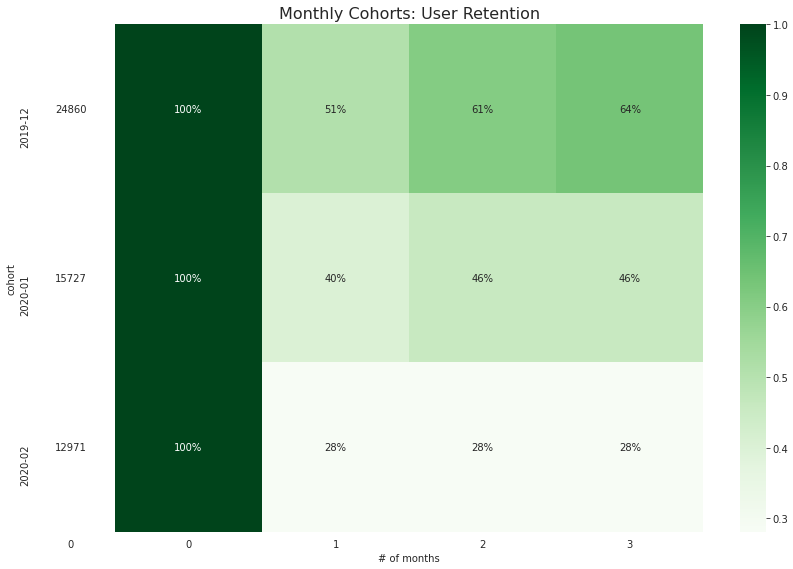

In [10]:
#visualize retention rate
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True, gridspec_kw={'width_ratios': [1,11]})
    
    sns.heatmap(retention_matrix,
               mask=retention_matrix.isnull(),
               annot=True,
               fmt='.0%',
               cmap='Greens',
               ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of months', ylabel='')
    
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
               annot=True,
               cbar=False,
               fmt='g',
               cmap=white_cmap,
               ax=ax[0])
    
    fig.tight_layout()